## Eval IO AE Correlation Patient-specific

In [ ]:
import os
import pickle
import datetime

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from preepiseizures.src import Patient, biosignal_processing
import Respiration_2023

In [ ]:
patient = 'YIVL'

data = pd.read_parquet('data/respiration/{patient}_all_respiration_data.parquet'.format(patient=patient))

patient_info = Patient.patient_class(patient)
patient_info.get_seizure_annotations()
patient_info.seizure_table

# data['datetime'] += pd.Timedelta(patient_info.patient_dict['temporal_shift'])


In [ ]:
corr_points = pd.read_parquet('preepiseizures/sudep_analysis/{patient}_corr_points_1s.parquet'.format(patient=patient))

In [ ]:
corr_points.index.name = 'datetime'
corr_points.reset_index(inplace=True)

In [ ]:
# corr points during seizures
for seiz in range(len(patient_info.seizure_table)):
    onset = patient_info.seizure_table.iloc[seiz]['Timestamp']
    corr_seizure = corr_points.loc[(corr_points['datetime'] >= onset - pd.Timedelta(minutes=60)) & (corr_points['datetime'] <= onset + pd.Timedelta(minutes=60))]
print(patient_info.seizure_table)

In [ ]:
corr_points

In [ ]:
fig = px.line(corr_points, x='datetime', y='corr',  title='Correlation between respiration and EEG')

for o in range(len(patient_info.seizure_table)):
    onset = patient_info.seizure_table.iloc[o]['Timestamp']
    fig.add_vline(x=onset, line_width=1, line_dash="dash", line_color="red")
fig.show()

In [ ]:
resp_rate, resp_times = biosignal_processing.resp_rate(data['RESP'], 80)

In [ ]:
resp_rate_df = pd.DataFrame({'datetime': data.iloc[resp_times]['datetime'], 'resp_rate': resp_rate})

In [ ]:
fig = px.scatter(resp_rate_df, x='datetime', y='resp_rate',  title='Correlation between respiration and EEG')

for o in range(len(patient_info.seizure_table)):
    onset = patient_info.seizure_table.iloc[o]['Timestamp']
    fig.add_vline(x=onset, line_width=1, line_dash="dash", line_color="red")
fig.update_yaxes(range=[0, 40])  
fig.show()

In [ ]:
fictional_time = datetime.datetime(2021, 1, 1, 0, 0, 0)
data_seizures = pd.DataFrame()
corr_points_seizures = pd.DataFrame()
# get seizure times
for i in range(len(patient_info.seizure_table)):
    #if patient_info.seizure_table.iloc[i]['Focal / Generalisada'] != 'FBTC':
    #    continue
    onset = patient_info.seizure_table['Timestamp'].iloc[i]
    start = onset - pd.Timedelta(minutes=60)
    end = onset + pd.Timedelta(minutes=60)
    seizure_i_data = data.loc[data['datetime'].between(start, end)].copy()
    if seizure_i_data.empty:
        continue
    seizure_i_data['seizure'] = i
    seizure_i_data['relative_time'] = seizure_i_data['datetime'] - onset
    seizure_i_data['onset'] = False
    seizure_i_data['onset'].iloc[np.argmin(np.abs(seizure_i_data['relative_time']))] = True
    corr_points_seizure_i = corr_points.loc[corr_points['datetime'].between(start, end)].copy()
    if corr_points_seizure_i.empty:
        continue
    corr_points_seizure_i['seizure'] = i
    corr_points_seizure_i['relative_time'] = corr_points_seizure_i['datetime'] - onset
    corr_points_seizure_i['onset'] = False
    corr_points_seizure_i['onset'].iloc[np.argmin(np.abs(corr_points_seizure_i['relative_time']))] = True

    seizure_i_data['fictional_time'] = fictional_time + seizure_i_data['relative_time']
    corr_points_seizure_i['fictional_time'] = fictional_time + corr_points_seizure_i['relative_time']
    seizure_i_data['index'] = np.arange(len(seizure_i_data))
    resp_rate, resp_times = biosignal_processing.resp_rate(seizure_i_data['RESP'], 80)
    seizure_i_data['resp_rate'] = np.nan
    seizure_i_data['resp_rate'].iloc[np.array(resp_times)-1] = resp_rate
    data_seizures = pd.concat((data_seizures, seizure_i_data), ignore_index=True)
    corr_points_seizure_i['corr'] = corr_points_seizure_i['corr'].astype(float)
    corr_points_seizure_i['index'] = np.arange(len(corr_points_seizure_i))
    #corr_points_seizure_i['label'] = np.hstack(['preictal'] * len(corr_points_seizure_i.loc[corr_points_seizure_i['datetime'].
    #                                                                              between(start, onset)]) + ['ictal'] * len(corr_points_seizure_i.loc[corr_points_seizure_i['datetime'].between(onset, onset + pd.Timedelta(minutes=2))]) + ['postictal'] * len(corr_points_seizure_i.loc[corr_points_seizure_i['datetime'].between(onset + pd.Timedelta(minutes=2), end)]))
    corr_points_seizures = pd.concat((corr_points_seizures, corr_points_seizure_i), ignore_index=True)

In [ ]:
data_seizures

In [ ]:

fig = sns.lmplot( data=corr_points_seizures, hue='onset', palette=['#83A19B'], y='corr', x='index', col='seizure', order=3, fit_reg=True, col_wrap=3, sharex=False, sharey=False)
i = 1

for axis in fig.axes:
    seizure_i_data = corr_points_seizures.loc[corr_points_seizures['seizure']==i].copy()
    if seizure_i_data.empty:
        continue
    axis.set_xlabel('Time (s)')
    axis.set_ylabel('Correlation Points')
    axis.set_ylim(-1, 1)#seizure_i_data['resp_rate'].max()+1)
    axis.lines[0].set_color('#03587B')
    axis.set_xticks(seizure_i_data['index'][::len(seizure_i_data)//8])
    axis.set_xticklabels(seizure_i_data['datetime'][::len(seizure_i_data)//8].dt.strftime('%H:%M:%S'), rotation=45)
    axis.vlines(seizure_i_data.loc[seizure_i_data['onset']==True, 'index'], -1, 1, color='#951428')
    i += 1

plt.savefig(f'data/figures{os.sep}{patient}_correlation_seizures.pdf')
# plt.xticks(corr_points_seizure_i['index'][::100], corr_points_seizure_i['relative_time'][::100], rotation=45)

In [ ]:

fig = sns.lmplot( data=data_seizures, hue='onset', palette=['#83A19B'], y='resp_rate', x='index', col='seizure', order=4, fit_reg=True, col_wrap=3, sharex=False, sharey=False)
i = 1

for axis in fig.axes:
    seizure_i_data = data_seizures.loc[data_seizures['seizure']==i].copy()
    if seizure_i_data.empty:
        continue
    axis.set_xlabel('Time (s)')
    axis.set_ylabel('Respiration rate (breaths/min)')
    axis.set_ylim(0, 35)#seizure_i_data['resp_rate'].max()+1)
    axis.lines[0].set_color('#03587B')
    axis.set_xticks(seizure_i_data['index'][::len(seizure_i_data)//8])
    axis.set_xticklabels(seizure_i_data['datetime'][::len(seizure_i_data)//8].dt.strftime('%H:%M:%S'), rotation=45)
    axis.vlines(seizure_i_data.loc[seizure_i_data['onset']==True, 'index'], 0, 50, color='#951428')
    i += 1

plt.savefig(f'data/figures{os.sep}{patient}_respiration_rate_seizures.pdf')

## Correlation plot during the entire validation set

In [ ]:
patient_list = [pat.split('_')[0] for pat in os.listdir('data/autoencoders_epilepsy/') if pat.endswith('_corr_points_1s.parquet')]

for patient in patient_list:
    image_file = f'data{os.sep}figures{os.sep}{patient}_respiration_correlation_all_limited.pdf'
    print('processing patient {patient}'.format(patient=patient))
    if os.path.exists(image_file):
        print('Image exists, skipping patient {patient}'.format(patient=patient))
        continue
    patient_info = Patient.patient_class(patient)
    patient_info.get_seizure_annotations()
    corr_points = pd.read_parquet('data/autoencoders_epilepsy/{patient}_corr_points_1s.parquet'.format(patient=patient))
    corr_points.index.name = 'datetime'
    fig = px.line(corr_points, y='corr',  title='Correlation IO Autoencoder Respiration for {patient}'.format(patient=patient))
    fig.update_yaxes(range=[0.4, 1])

    if 'Timestamp' not in patient_info.seizure_table.columns:
        fig.write_image(image_file)
        continue
    for o in range(len(patient_info.seizure_table)):
        onset = patient_info.seizure_table.iloc[o]['Timestamp']
        fig.add_vline(x=onset, line_width=1, line_dash="dash", line_color="red")
    fig.update_yaxes(range=[0.4, 1])
    fig.write_image(image_file)



## Correlation points in the periictal region of seizure types

In [13]:
patient_list = [pat.split('_')[0] for pat in os.listdir('data/autoencoders_epilepsy/') if pat.endswith('_corr_points_1s.parquet')]

corr_points_all = pd.DataFrame()

for patient in patient_list:
    #image_file = f'data{os.sep}figures{os.sep}{patient}_respiration_correlation_all_limited.pdf'
    print('processing patient {patient}'.format(patient=patient))
    #if os.path.exists(image_file):
    #    print('Image exists, skipping patient {patient}'.format(patient=patient))
    #    continue
    patient_info = Patient.patient_class(patient)
    patient_info.get_seizure_annotations()
    corr_points = pd.read_parquet('data/autoencoders_epilepsy/{patient}_corr_points_1s.parquet'.format(patient=patient))
    corr_points.index.name = 'datetime'
    corr_points['patient'] = patient
    corr_points.reset_index(inplace=True)

    #fig = px.line(corr_points, y='corr',  title='Correlation IO Autoencoder Respiration for {patient}'.format(patient=patient))
    #fig.update_yaxes(range=[0.4, 1])
    corr_points['index'] = 0
    corr_points['seizure_type'] = ''
    corr_points['region'] = 'interictal'

    if 'Timestamp' not in patient_info.seizure_table.columns:
    #    fig.write_image(image_file)
        continue
    for o in range(len(patient_info.seizure_table)):
        onset = patient_info.seizure_table.iloc[o]['Timestamp']
        corr_points.loc[corr_points['datetime'].between(onset - pd.Timedelta(minutes=60), onset + pd.Timedelta(minutes=60)), 'region'] = 'periictal'
        corr_points.loc[corr_points['datetime'].between(onset - pd.Timedelta(minutes=60), 
                                                        onset + pd.Timedelta(minutes=60)), 'seizure_type'] = patient_info.seizure_table.iloc[o]['Focal / Generalisada']
        corr_points.loc[corr_points['datetime'].between(onset - pd.Timedelta(minutes=60), 
                                                        onset + pd.Timedelta(minutes=60)), 'index'] = np.arange(len(corr_points.loc[corr_points['datetime'].between(onset - pd.Timedelta(minutes=60), 
                                                                                                                                                                    onset + pd.Timedelta(minutes=60))]))

    #    fig.add_vline(x=onset, line_width=1, line_dash="dash", line_color="red")
    #fig.update_yaxes(range=[0.4, 1])
    #fig.write_image(image_file)
    corr_points_all = pd.concat((corr_points_all, corr_points), ignore_index=True)


processing patient UDZG
processing patient UIJU
processing patient DDEX
processing patient TZPY
No seizure annotations found for patient TZPY
processing patient QJBW
Seizure label file not found for patient QJBW
No seizure annotations found for patient QJBW
processing patient XEUD
processing patient WZFI
Seizure label file not found for patient WZFI
No seizure annotations found for patient WZFI
processing patient NJML
processing patient MQWA
processing patient OFUF
processing patient PZEF
processing patient CJMJ
processing patient PGSE
processing patient VNVW
processing patient AGGA
processing patient RMJL
processing patient SYRH
processing patient PRBQ
processing patient LGOH
processing patient EXRE
processing patient LCGM
processing patient YWJN
processing patient SZLU
processing patient CNSV
processing patient RAFI
processing patient MHDG
No seizure annotations found for patient MHDG
processing patient QDST
No seizure annotations found for patient QDST
processing patient KHTG
Seizur

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning:

Polyfit may be poorly conditioned

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning:

Polyfit may be poorly conditioned

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py

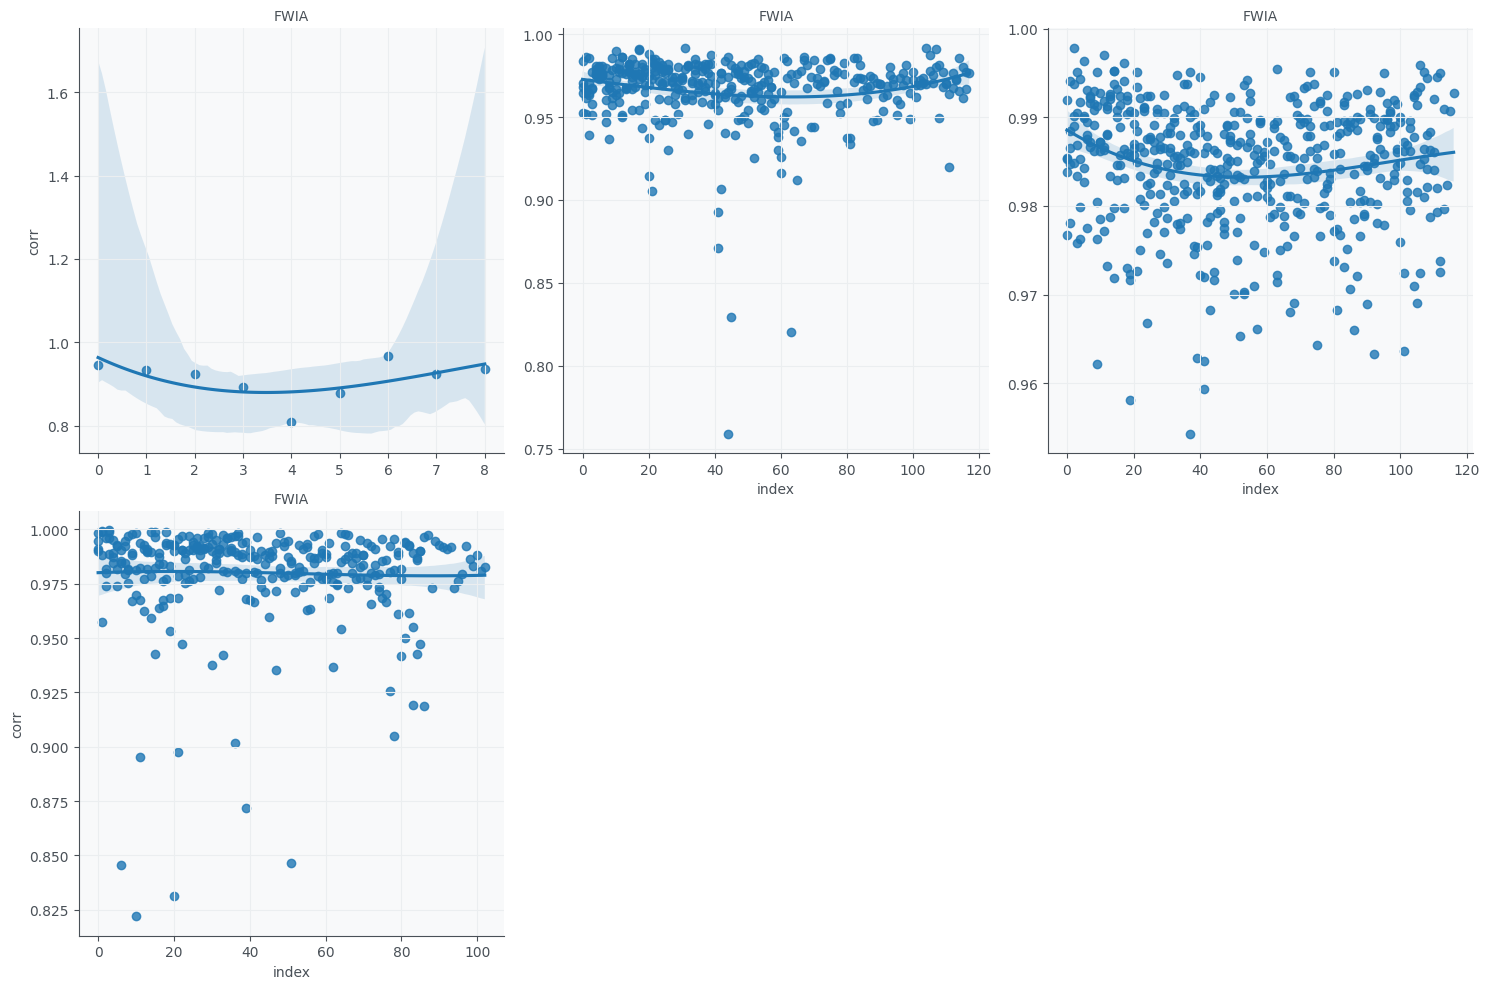

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



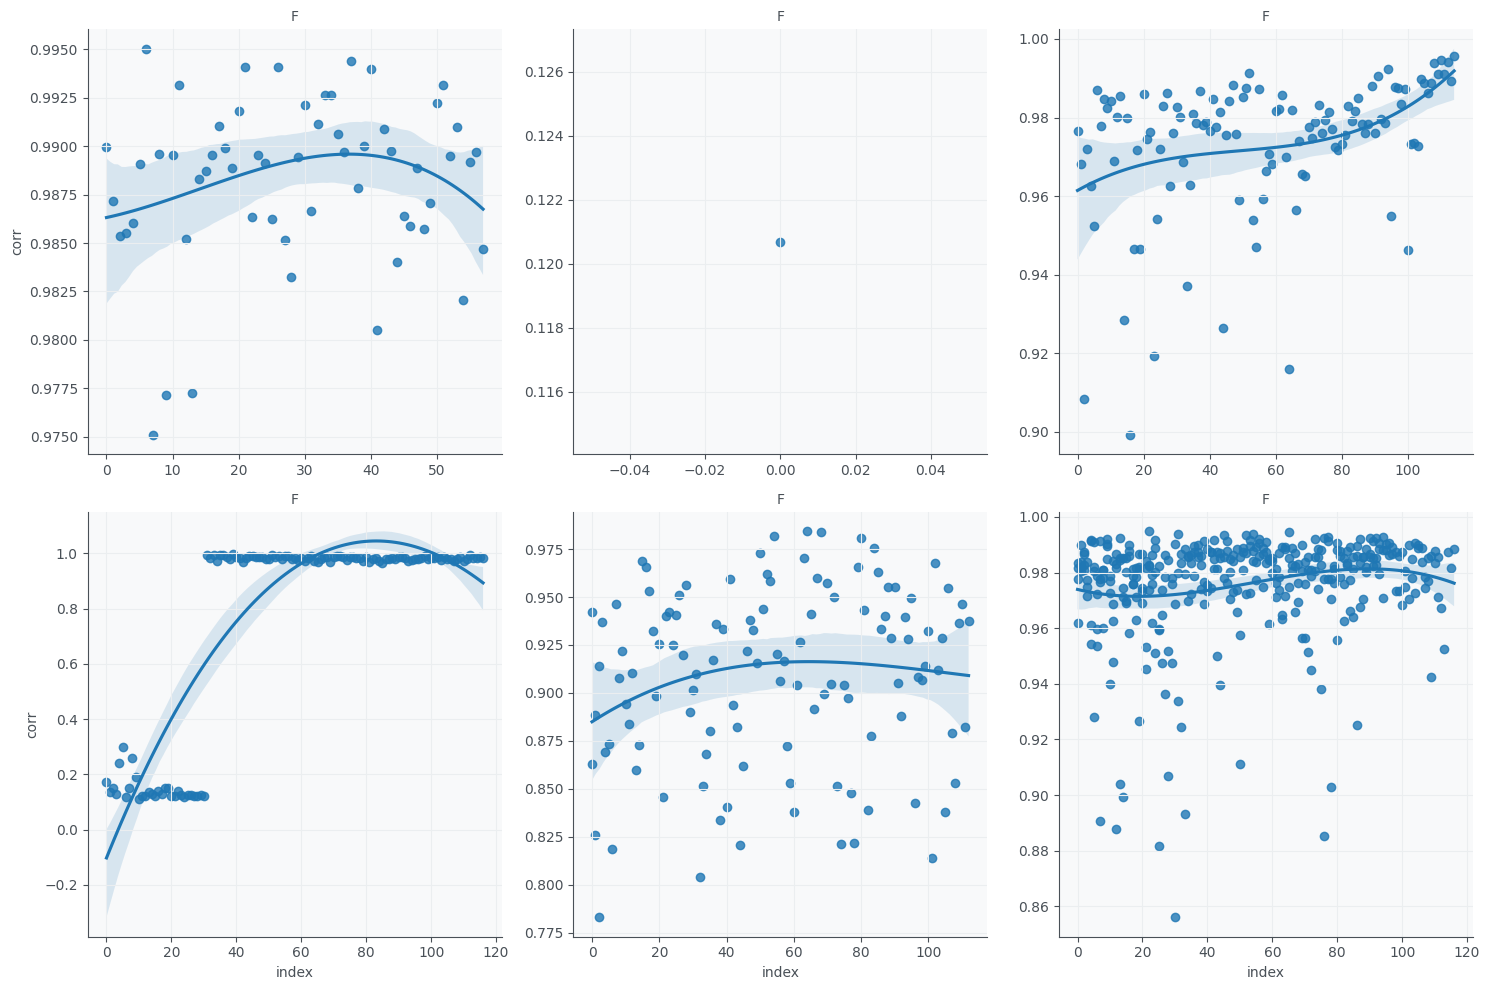

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



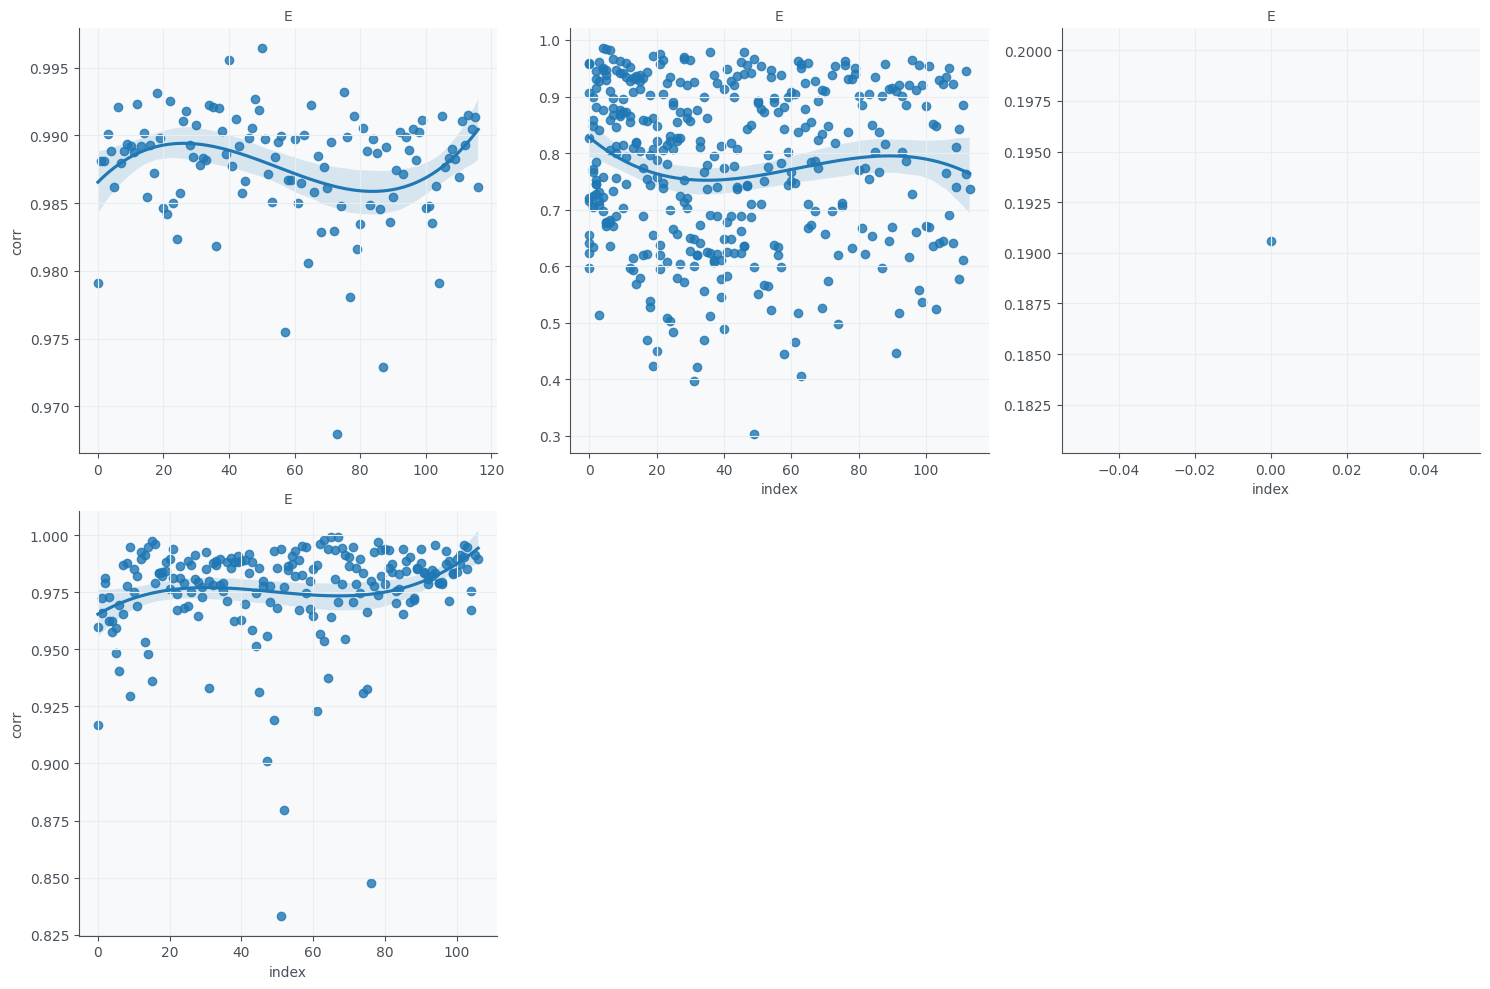

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



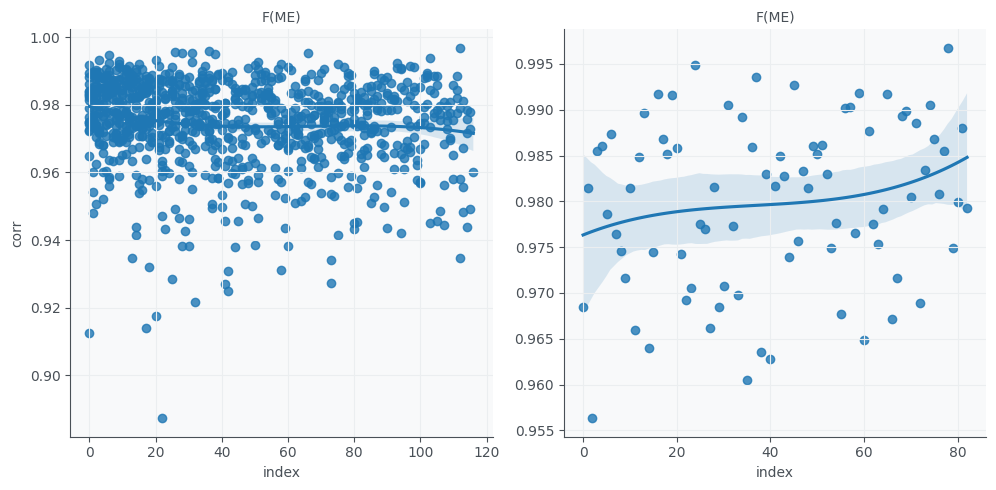

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



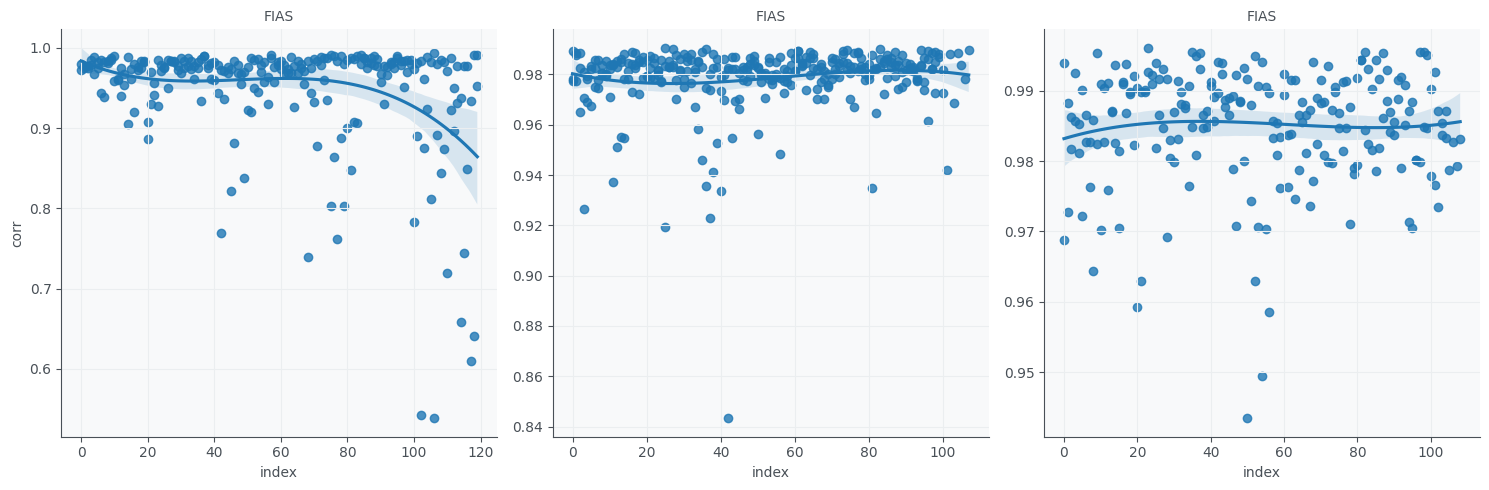

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



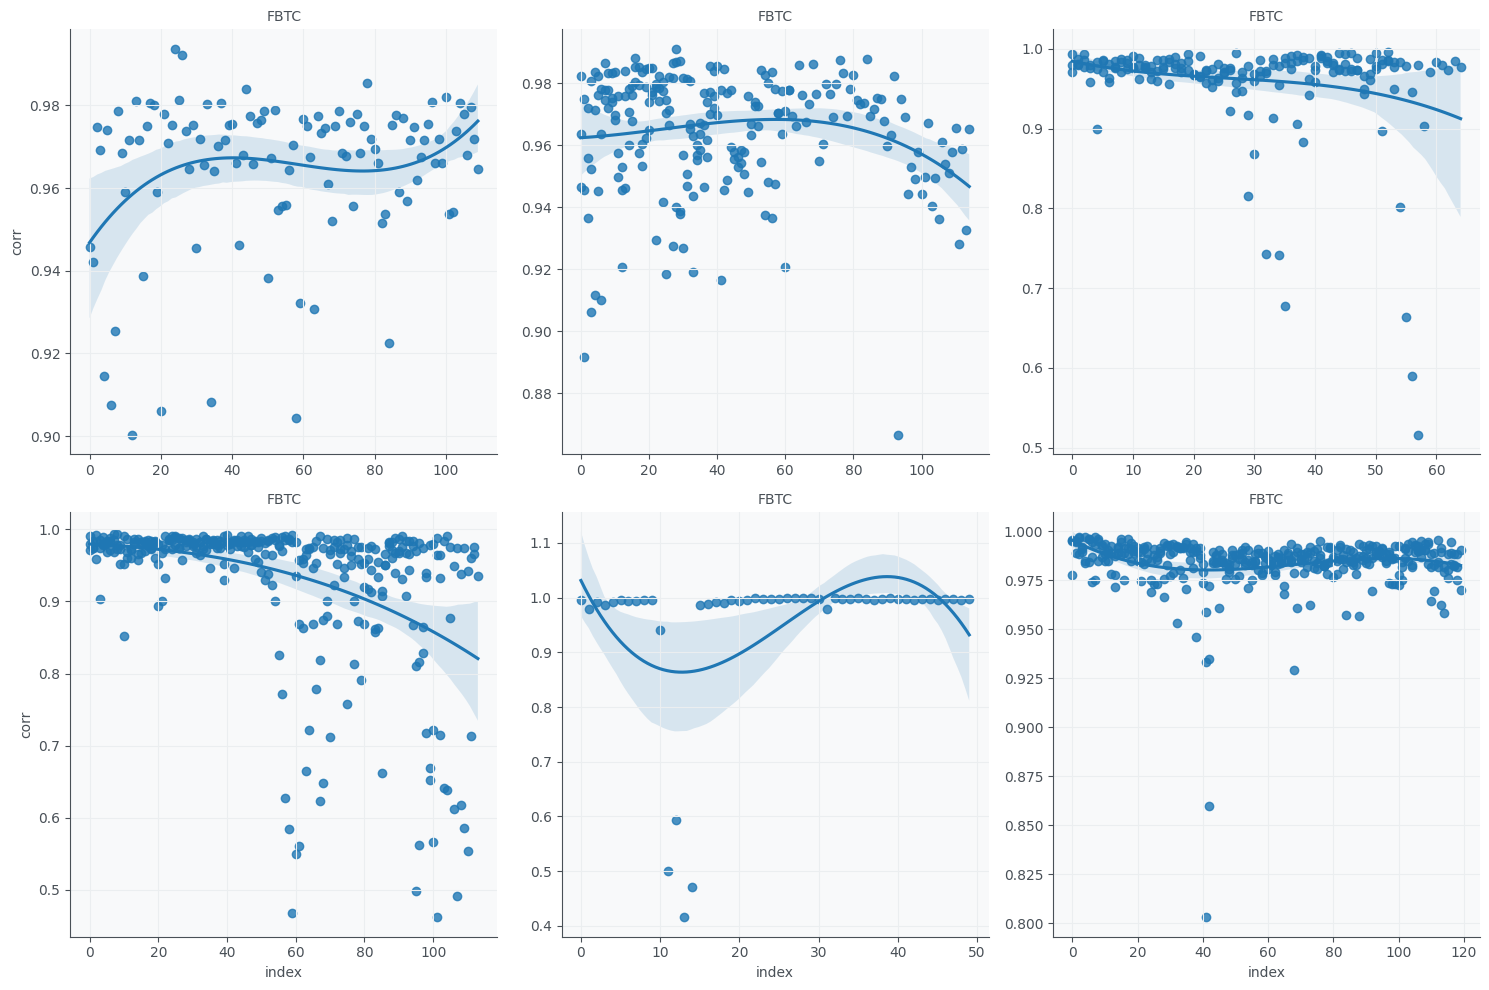

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



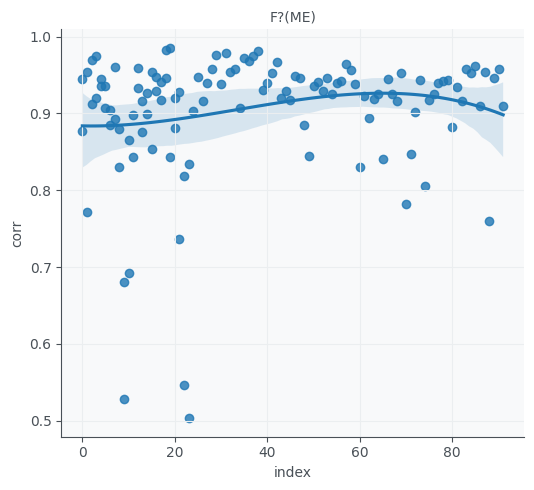

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



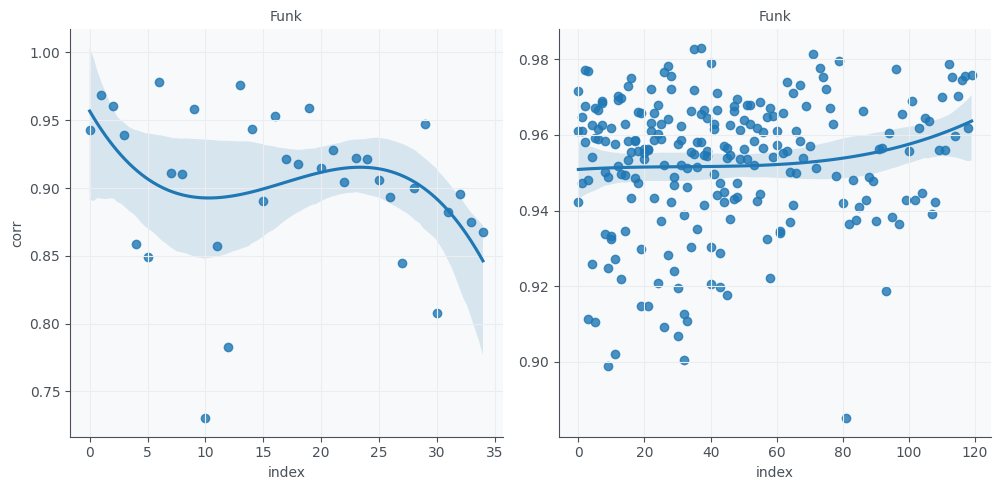

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



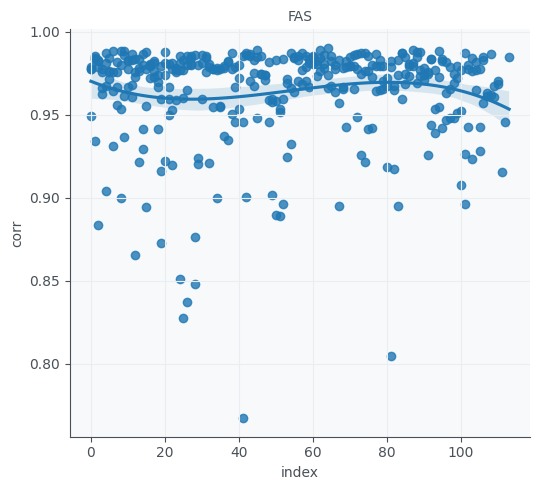

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



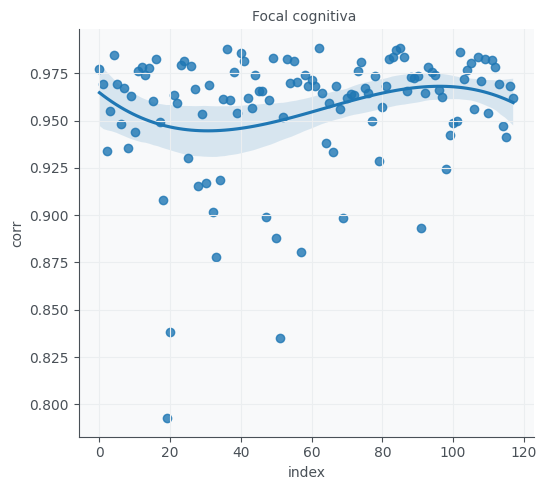

In [27]:
for seizure_type in corr_points_all['seizure_type'].unique():
    if seizure_type == '':
        continue
    corr_seizures = corr_points_all.loc[corr_points_all['seizure_type']==seizure_type].copy()
    fig = sns.lmplot( data=corr_seizures, palette=['#83A19B'], y='corr', x='index', col='patient', order=3, fit_reg=True, col_wrap=3, sharex=False, sharey=False)
    fig.set_titles(f'{seizure_type}')
    plt.show()

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:598: UserWarning:

sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning:

Polyfit may be poorly conditioned

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py:261: RankWarning:

Polyfit may be poorly conditioned

/Users/saraiva/dev/PreEpiSeizuresCode/.venv/lib/python3.11/site-packages/seaborn/regression.py

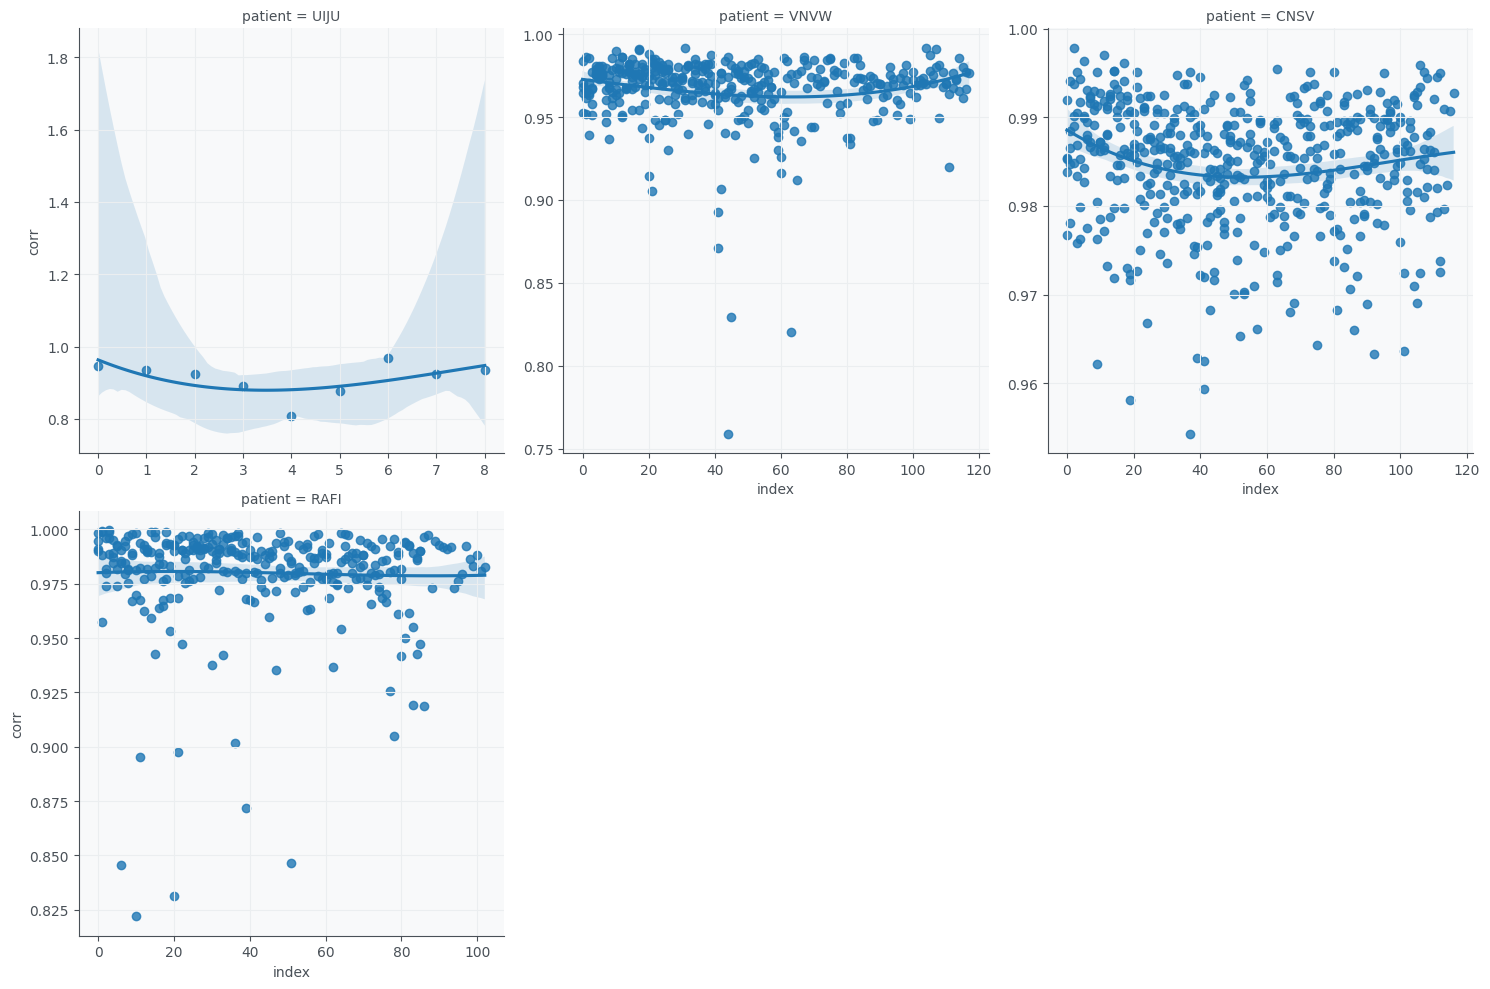

In [25]:

i = 1

# for axis in fig.axes:
#     seizure_i_data = corr_seizures.loc[corr_seizures['seizure']==i].copy()
#     if seizure_i_data.empty:
#         continue
#     axis.set_xlabel('Time (s)')
#     axis.set_ylabel('Correlation Points')
#     axis.set_ylim(-1, 1)#seizure_i_data['resp_rate'].max()+1)
#     axis.lines[0].set_color('#03587B')
#     axis.set_xticks(seizure_i_data['index'][::len(seizure_i_data)//8])
#     axis.set_xticklabels(seizure_i_data['datetime'][::len(seizure_i_data)//8].dt.strftime('%H:%M:%S'), rotation=45)
#     axis.vlines(seizure_i_data.loc[seizure_i_data['onset']==True, 'index'], -1, 1, color='#951428')
#     i += 1

plt.savefig(f'data/figures{os.sep}{patient}_correlation_seizures.pdf')